In [1]:
import pandas as pd
import numpy as np
import sys, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score


## Data Cleaning

In [2]:
root = 'data/Presential_Speeches'

In [9]:
test = 'data/Presential_Speeches'

In [10]:
test[-9:]

'_Speeches'

### Get all document paths

In [3]:
all_docs = []
for path, sub, filen in os.walk(root):
#     print 'PPP', path
#     print 'SSS', sub
#     print 'FFF', filen
    if path[-9:]!='_Speeches':
        for f in filen:
            doc_path = path+'/'+f
            all_docs.append(doc_path)

In [4]:
#all_docs

In [5]:
df = pd.DataFrame({'path':all_docs, 'doc_id':range(1,len(all_docs)+1)})

In [6]:
('data/Presential_Speeches/').split('/')

['data', 'Presential_Speeches', '']

In [7]:
df['president'] = df['path'].apply(lambda x: x.split('/')[2])

In [8]:
def read_file(path):
    with open(path) as f:
        content = f.read()
    #postString = content.split("\n")[2]
    return content


In [9]:
df['speech_content'] = df['path'].apply(read_file)

In [10]:
pd.set_option('display.max_colwidth', -1)

In [11]:
#df.head()

In [12]:
df.shape

(962, 4)

In [13]:
#df.head()

### Manually tag each president's party

In [14]:
pre_par = {'adams': 'Federalist',
 'arthur': 'Republican',
 'bharrison': 'Republican',
 'buchanan': 'Democratic',
 'bush': 'Republican',
 'carter': 'Democratic',
 'cleveland': 'Democratic',
 'clinton': 'Democratic',
 'coolidge': 'Republican',
 'eisenhower': 'Republican',
 'fdroosevelt': 'Democratic',
 'fillmore': 'Whig',
 'ford': 'Republican',
 'garfield': 'Republican',
 'grant': 'Republican',
 'gwbush': 'Republican',
 'harding': 'Republican',
 'harrison': 'Whig',
 'hayes': 'Republican',
 'hoover': 'Republican',
 'jackson': 'Democratic',
 'jefferson': 'Democratic-Republican',
 'johnson': 'National Union',
 'jqadams': 'Democratic-Republican',
 'kennedy': 'Democratic',
 'lbjohnson': 'Democratic',
 'lincoln': 'Republican',
 'madison': 'Democratic-Republican',
 'mckinley': 'Republican',
 'monroe': 'Democratic-Republican',
 'nixon': 'Republican',
 'obama': 'Democratic',
 'pierce': 'Democratic',
 'polk': 'Democratic',
 'reagan': 'Republican',
 'roosevelt': 'Republican',
 'taft': 'Republican',
 'taylor': 'Whig',
 'truman': 'Democratic',
 'tyler': 'Whig',
 'vanburen': 'Democrat',
 'washington': 'none',
 'wilson': 'Democratic'}

In [15]:
df['party'] = df['president'].apply(lambda x: pre_par[x])

In [16]:
#df[['president','party']].head(80)

In [17]:
df_new = df[(df['party']=='Republican')|(df['party']=='Democratic')]

In [18]:
# take only republican and democratic presidents to train the models
df_new.shape

(797, 5)

### Examine the class balance between Republican and Democratic

In [19]:
1.*sum(df_new['party']=='Republican')/df_new.shape[0]

0.45294855708908405

**looks pretty balanced**

In [20]:
#X = df_new[['path','speech_content']]
X = df_new['speech_content']
y = df_new['party']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
X.shape

(797,)

In [22]:
#X.head()

In [23]:
1.*sum(y=='Republican')/y.shape[0]

0.45294855708908405

In [24]:
1.*sum(y_test=='Republican')/y_test.shape[0]

0.5

### Text Data Preprocessing

In [25]:
vectorizer = TfidfVectorizer(stop_words='english')

In [26]:
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [27]:
X_train_dtm.shape

(597, 29292)

In [28]:
X_test_dtm.shape

(200, 29292)

### Modeling

**Logistic Regression**

In [29]:
from nltk.stem.snowball import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

**Due to computation limit, here I used only PorterStemmer. With distributed computation, more stemming/lemmatization choices can be tested in GridSearch**

In [205]:
# Gridsearch on text feature extractor and classfier hyper params
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', analyzer=stemmed_words)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    'vect__max_df': (0.5, 0.75),
    #'vect__max_features': (None, 5000, 10000),
    'vect__ngram_range': ((1, 2), (1, 3)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C':[0.01,0.1,1],
    'clf__penalty': ('l2', 'l1')
    #'clf__n_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 17.1min finished


Best score: 0.739
Best parameters set:


In [207]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 1
	clf__penalty: 'l2'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [208]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', analyzer=stemmed_words, max_df=0.5, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('clf', LogisticRegression(C=1, penalty='l2')),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x1a1e3e8050>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=0.5,
        max_features=None, min_df=1, ngram_range=(1, 2), preprocessor=...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [209]:
y_pred = pipeline.predict(X_test)

In [218]:
y_test_num = y_test=='Republican'
y_pred_num = y_pred=='Republican'

In [280]:
accuracy_score(y_test_num, y_pred_num)

0.755

In [284]:
precision_score(y_test_num, y_pred_num)

0.84848484848484851

In [285]:
recall_score(y_test_num, y_pred_num)

0.58947368421052626

In [287]:
roc_auc_score(y_test_num, y_pred_num)

0.74711779448621551

**Naive Bayes**

In [30]:
y_train_num = y_train=='Republican'

In [31]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

def lemm_words(doc):
    return (lemm.lemmatize(w) for w in analyzer(doc))

In [32]:
pipeline = Pipeline([
    #('vect', CountVectorizer(stop_words='english', analyzer=lemm_words)),
    ('vect', CountVectorizer(stop_words='english', analyzer=stemmed_words)),
    #('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

parameters = {
    'vect__max_df': (0.5, 0.75),
    #'vect__max_features': (None, 5000, 10000),
    'vect__ngram_range': ((1, 1), (1, 2))  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha':[1,None]
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train_num)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.0min finished


Best score: 0.715
Best parameters set:
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


In [ ]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [33]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', analyzer=stemmed_words, max_df=0.5, ngram_range=(1,1))),
    ('clf', MultinomialNB())
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x1a1b349f50>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=0.5,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=...one,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [34]:
y_pred = pipeline.predict(X_test)

In [35]:
y_test_num = y_test=='Republican'
y_pred_num = y_pred=='Republican'

In [36]:
accuracy_score(y_test_num, y_pred_num)

0.75

**Precision score is slightly lower compare to Logistic Regression**

In [37]:
precision_score(y_test_num, y_pred_num)

0.79761904761904767

**Recall score is higher compare to Logistic Regression**

In [38]:
recall_score(y_test_num, y_pred_num)

0.67000000000000004

## Extra steps to explore the corpus

### What if we forget about the "party label", and do a unsupervised learning?

In [191]:
df.columns

Index([u'doc_id', u'path', u'president', u'speech_content', u'party'], dtype='object')

In [193]:
df_cluster = df['speech_content']

In [227]:
vectorizer = TfidfVectorizer(stop_words='english', analyzer=lemm_words, max_features=15000)
X_dtm = vectorizer.fit_transform(X)

In [228]:
X_dtm.shape

(797, 15000)

In [235]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [233]:
model = PCA(n_components=20)
model.fit(X_dtm.todense())

PCA(copy=True, n_components=20, whiten=False)

### Use scree plot to visualize latent feature importance

In [344]:
def scree_plot(pca, title=None):
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    plt.figure(figsize=(10, 6), dpi=250)
    ax = plt.subplot(111)
    ax.bar(ind, vals, 0.35)

    for i in xrange(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)

    ax.set_xticklabels(ind,
                       fontsize=6)

    ax.set_ylim(0, max(vals)+0.05)
    ax.set_xlim(0-0.5, 20)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component", fontsize=6)
    ax.set_ylabel("Variance Explained (%)", fontsize=6)

    if title is not None:
        plt.title(title, fontsize=16)

In [345]:
model.n_components_

20

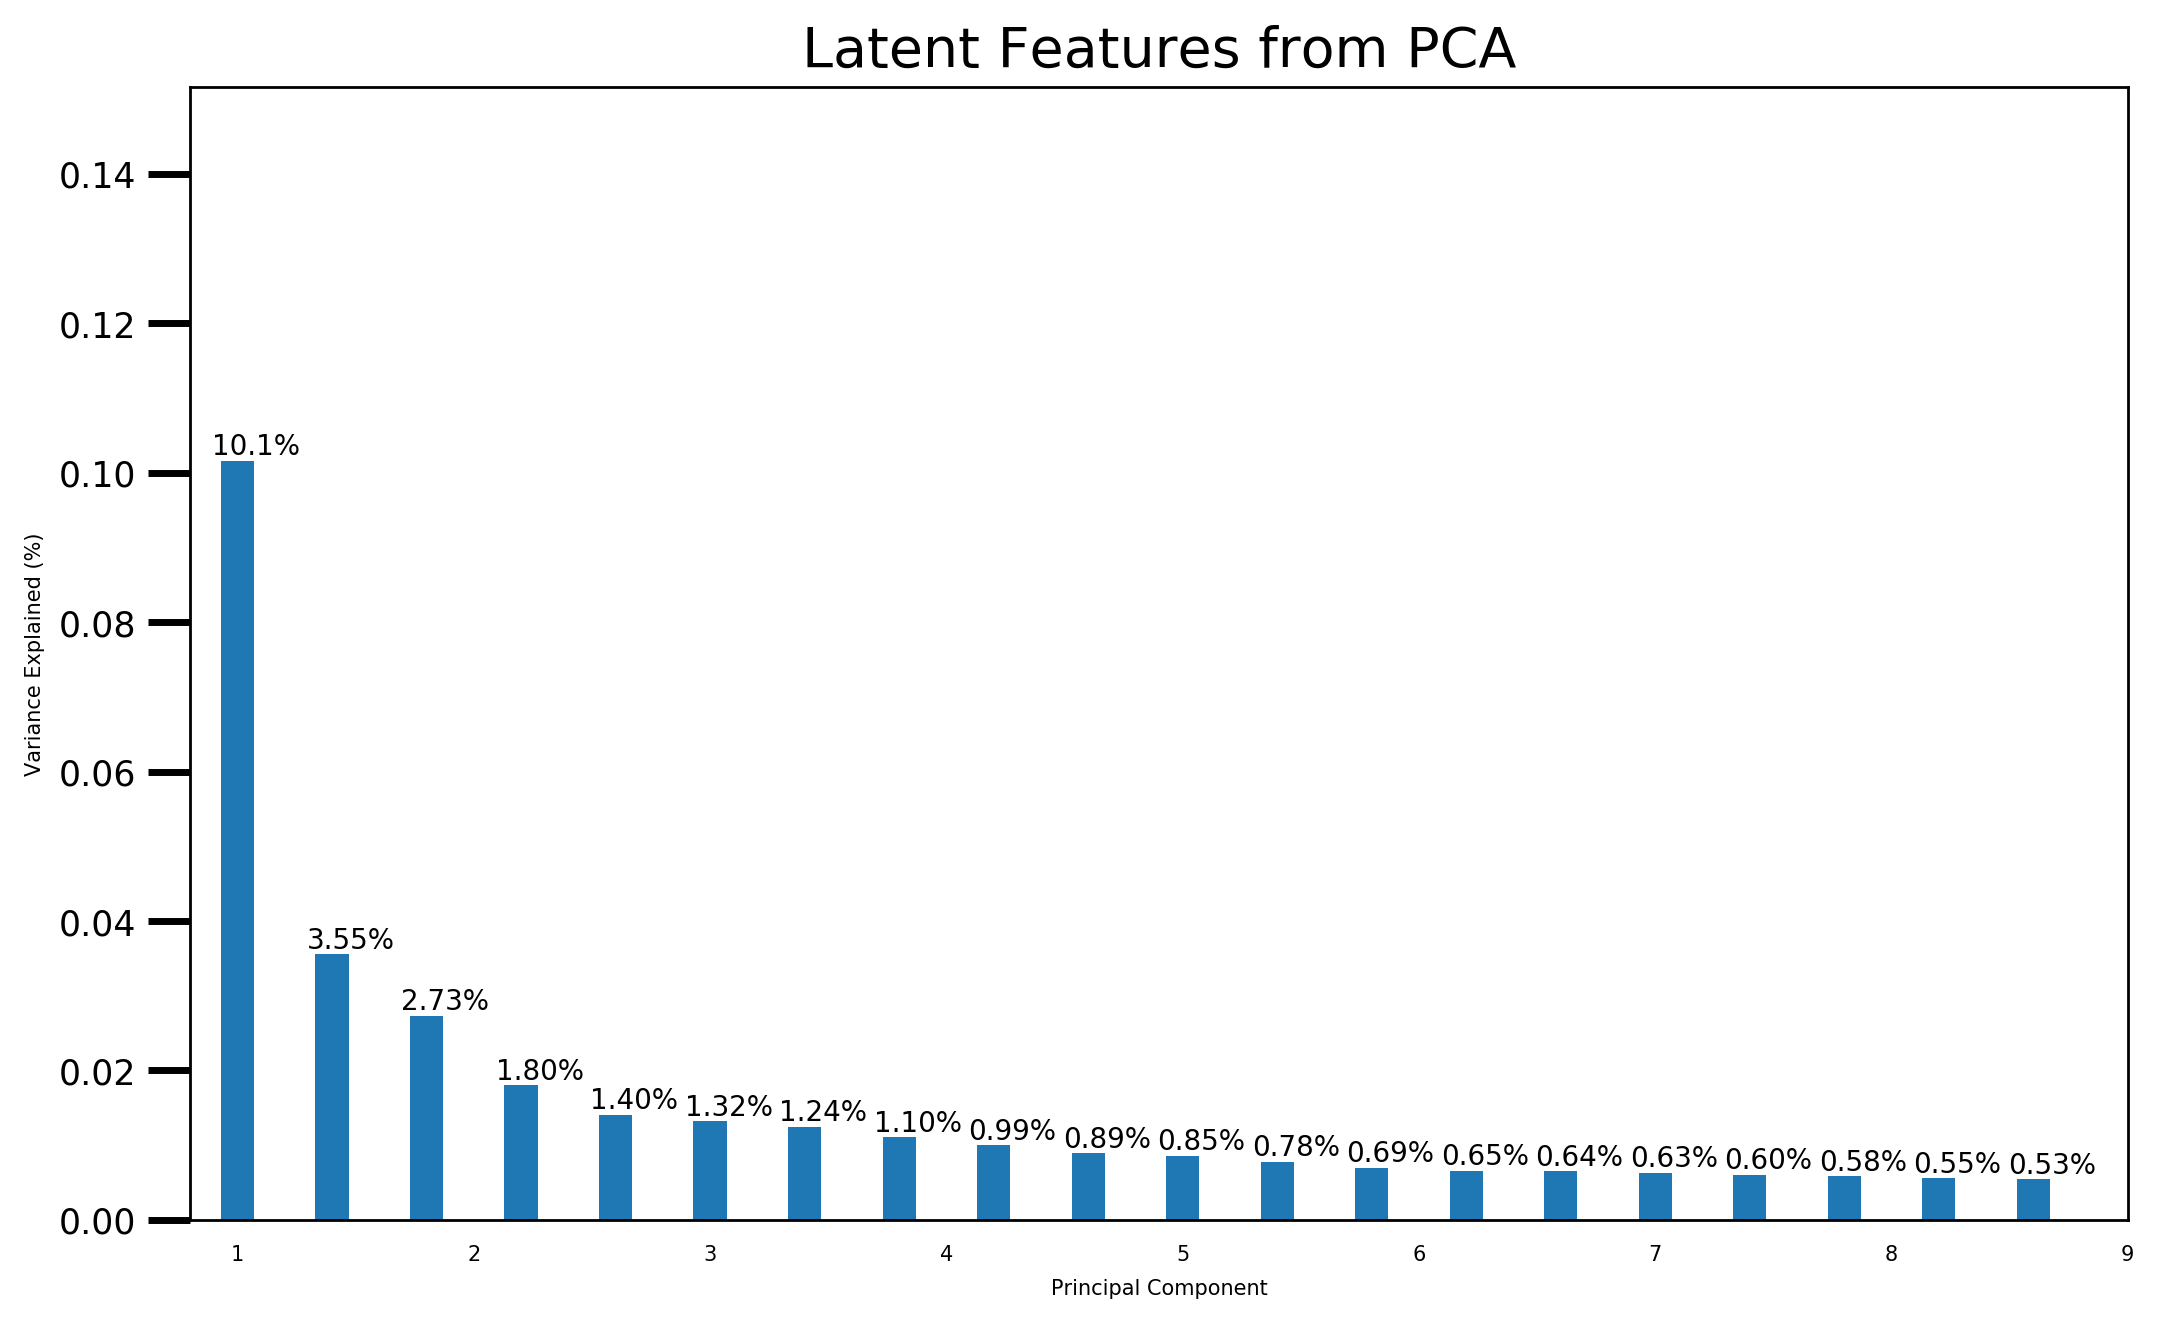

In [346]:
scree_plot(model, title='Latent Features from PCA')

### The first 3 components shows significant variance explanation

In [256]:
from sklearn.decomposition import NMF

In [258]:
model2 = NMF(n_components=10)
W = model2.fit_transform(X_dtm)
H = model2.components_

### We can examine H matrix to see what are some top words for each latent features

In [266]:
vocab = np.array(vectorizer.get_feature_names())

In [272]:
i = 1
for lf in H:
    #print type(lf)
    # Get the top 100 most important words starting from after some common words
    idx = lf.argsort()[::-1][11:111]
    top_w = vocab[idx]
    print i,': ',' '.join(top_w), '\n'
    i += 1

1 :  for a government not been with this have ha upon should from such wa or congress state law on are an at their would our any public 000 under may power will country duty no present these they other made shall if constitution subject were general interest but bill them condition treasury there year department provision question consideration appropriation than can tariff necessary senate bank act had all legislation service gold treaty during measure message without time attention case thus foreign relation expenditure federal report commerce business revenue officer right so authority national representative only court purpose amount result one 

2 :  american job our more congress program is it ve you budget help work their re child with family federal tonight economy cut people health america new energy percent business by bill school deficit who care inflation government plan million income thank spending oil be billion rate all now drug have need make must about from worker ref

### Topic Examine Result:
#### Topic 1: Business legislation
#### Topic 2: American jobs
#### Topic 3: Kenndy and Vietnam
#### Topic 4: Immigration and Education
#### Topic 5: Freedom, Democracy and Peace
#### Topic 6: Cuba and Panama
#### Topic 7: Gulf War
#### Topic 8: Freedom, Democracy and Peace
#### Topic 9: Southeast Asia and Vietnam
#### Topic 10: WWII